In [252]:
import torch
def warp_kpts(kpts0, depth0, depth1, T_0to1, K0, K1):
    """ Warp kpts0 from I0 to I1 with depth, K and Rt
    Also check covisibility and depth consistency.
    Depth is consistent if relative error < 0.2 (hard-coded).
    
    Args:
        kpts0 (torch.Tensor): [N, L, 2] - <x, y>,
        depth0 (torch.Tensor): [N, H, W],
        depth1 (torch.Tensor): [N, H, W],
        T_0to1 (torch.Tensor): [N, 3, 4],
        K0 (torch.Tensor): [N, 3, 3],
        K1 (torch.Tensor): [N, 3, 3],
    Returns:
        calculable_mask (torch.Tensor): [N, L]
        warped_keypoints0 (torch.Tensor): [N, L, 2] <x0_hat, y1_hat>
    """
    kpts0_long = kpts0.round().long()

    # Sample depth, get calculable_mask on depth != 0
    kpts0_depth = torch.stack(
        [depth0[i, kpts0_long[i, :, 1], kpts0_long[i, :, 0]] for i in range(kpts0.shape[0])], dim=0
    )  # (N, L)
    nonzero_mask = kpts0_depth != 0

    # Unproject
    kpts0_h = torch.cat([kpts0, torch.ones_like(kpts0[:, :, [0]])], dim=-1) * kpts0_depth[..., None]  # (N, L, 3)
    kpts0_cam = K0.inverse() @ kpts0_h.transpose(2, 1)  # (N, 3, L)

    # Rigid Transform
    w_kpts0_cam = T_0to1[:, :3, :3] @ kpts0_cam + T_0to1[:, :3, [3]]    # (N, 3, L)
    w_kpts0_depth_computed = w_kpts0_cam[:, 2, :]

    # Project
    w_kpts0_h = (K1 @ w_kpts0_cam).transpose(2, 1)  # (N, L, 3)
    w_kpts0 = w_kpts0_h[:, :, :2] / (w_kpts0_h[:, :, [2]] + 1e-4)  # (N, L, 2), +1e-4 to avoid zero depth

    # Covisible Check
    h, w = depth1.shape[1:3]
    covisible_mask = (w_kpts0[:, :, 0] > 0) * (w_kpts0[:, :, 0] < w-1) * \
        (w_kpts0[:, :, 1] > 0) * (w_kpts0[:, :, 1] < h-1)
    w_kpts0_long = w_kpts0.long()
    w_kpts0_long[~covisible_mask, :] = 0

    w_kpts0_depth = torch.stack(
        [depth1[i, w_kpts0_long[i, :, 1], w_kpts0_long[i, :, 0]] for i in range(w_kpts0_long.shape[0])], dim=0
    )  # (N, L)
    consistent_mask = ((w_kpts0_depth - w_kpts0_depth_computed) / w_kpts0_depth).abs() < 0.2
    valid_mask = nonzero_mask * covisible_mask * consistent_mask

    return valid_mask, w_kpts0

In [253]:
from scipy.spatial.transform import Rotation as R


def get_poses(scene, root):
    """
    :param scene: Index of trajectory
    :param root: Root folder of dataset
    :return: all camera poses as quaternion vector and 4x4 projection matrix
    """
    locations = []
    rotations = []
    loc_reader = open(root + 'SavedPosition_' + scene + '.txt', 'r')
    rot_reader = open(root + 'SavedRotationQuaternion_' + scene + '.txt', 'r')
    for line in loc_reader:
        locations.append(list(map(float, line.split())))

    for line in rot_reader:
        rotations.append(list(map(float, line.split())))

    locations = np.array(locations)
    rotations = np.array(rotations)
    poses = np.concatenate([locations, rotations], 1)

    r = R.from_quat(rotations).as_matrix()

    TM = np.eye(4)
    TM[1, 1] = -1

    poses_mat = []
    for i in range(locations.shape[0]):
        ri = r[i]
        Pi = np.concatenate((ri, locations[i].reshape((3, 1))), 1)
        Pi = np.concatenate((Pi, np.array([0.0, 0.0, 0.0, 1.0]).reshape((1, 4))), 0)
        Pi_left = TM @ Pi @ TM   # Translate between left and right handed systems
        poses_mat.append(Pi_left)

    return poses, np.array(poses_mat)


def get_relative_pose(pose_t0, pose_t1):

    """
    :param pose_tx: 4x4 camera pose describing camera to world frame projection of camera x.
    :return: Position of camera 1's origin in camera 0's frame.
    """
    return np.matmul(np.linalg.inv(pose_t0), pose_t1)

In [264]:
def read_syntheticColon_depth(path,size = None):
    image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    depth_norm = (image) / (65535 - 0)
    depth = depth_norm * 20 #0-20cm
    if size != None:
        depth = cv2.resize(depth, size)

    depth = torch.from_numpy(depth[np.newaxis,:]).float()
    return depth

In [265]:
ratio = 640/475

In [273]:
from PIL import Image, ImageOps
import cv2
import numpy as np
img_name0 = 'C:/datasets/synapse/syntheticColon_I/Frames_S1/FrameBuffer_0000.png'
img_name1 = 'C:/datasets/synapse/syntheticColon_I/Frames_S1/FrameBuffer_0001.png'
image0 = Image.open(img_name0)
image0 = ImageOps.grayscale(image0)
image0 = (np.array(image0)).astype('f')
image0 = cv2.resize(image0,((640,640)))
#    augment_fn=np.random.choice([self.augment_fn, None], p=[0.5, 0.5]))
image1 = Image.open(img_name1)
image1 = ImageOps.grayscale(image1)
image1 = np.array(image1).astype('f')
image1 = cv2.resize(image1,((640,640)))
#    augment_fn=np.random.choice([self.augment_fn, None], p=[0.5, 0.5]))
_, poses = get_poses('S1','C:/datasets/synapse/syntheticColon_I/')
T_0to1 =  torch.tensor(get_relative_pose(poses[1],poses[0]).astype('f'))[np.newaxis,:]
T_1to0 = T_0to1.inverse()
K_1 = K_0 = torch.tensor(np.array([[227.60416*ratio, 0, 227.60416*ratio],[0,237.5*ratio,237.5*ratio], [0,0,1]],dtype='f'))
depth_name0 = 'C:/datasets/synapse/syntheticColon_I/Frames_S1/Depth_0000.png'
depth_name1 = 'C:/datasets/synapse/syntheticColon_I/Frames_S1/Depth_0001.png'
depth0 = read_syntheticColon_depth(depth_name0,(640,640))

depth1 = read_syntheticColon_depth(depth_name1,(640,640))

In [274]:
x = np.array([[[0,0],[150,270],[90,395],[200,220],[360,350],[320,320],[460,460]]],dtype='f')
xx = x[0,:,0]
yy = x[0,:,1]
print(x.shape)
x = torch.from_numpy(x)
a,out = warp_kpts(x,depth0,depth1,T_0to1,K_0,K_1)
xhat = np.array(out)[0,:,0]
yhat = np.array(out)[0,:,1]

(1, 7, 2)


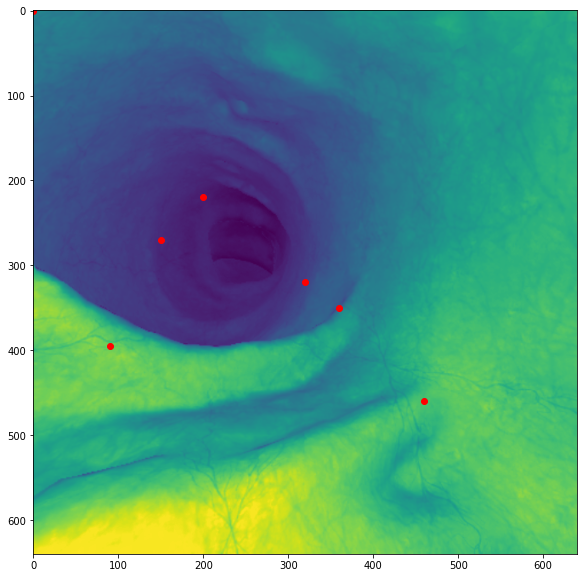

In [275]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.imshow(image0)
plt.scatter(xx, yy, c='r')

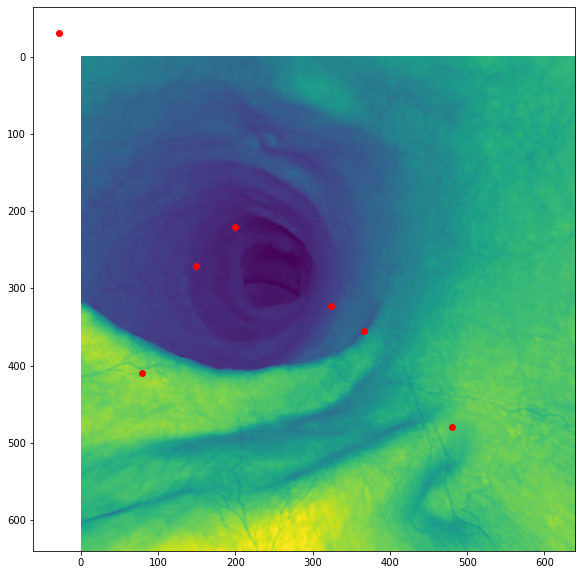

In [276]:
plt.figure(figsize = (10,10))
plt.imshow(image1)
plt.scatter(xhat, yhat,c='r')